In [1]:
import numpy as np
import pandas as pd
from math import sqrt

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split,cross_val_score,cross_validate
from sklearn.model_selection import TimeSeriesSplit

from sklearn import linear_model
from sklearn.linear_model import Lasso,LassoCV,LassoLarsCV 

In [2]:
# Import datasets
returns = pd.read_excel("Returns_Clean.xlsx", index_col = 'Dates')
returns.index = pd.to_datetime(returns.index, format='%Y%m%d')

flows = pd.read_excel("Flows_Clean.xlsx", index_col = 'Dates')
flows.index = pd.to_datetime(flows.index, format='%Y%m%d')

returns_labeled = returns.copy()
returns_labeled.columns =['return_'+str(i) for i in returns.columns]
flows_labeled = flows.copy()
flows_labeled.columns = ['flow_'+str(i) for i in flows.columns]

print(returns_labeled.head())
print(flows_labeled.head())
print(len(returns))

            return_55976  return_41072  return_27748  return_75259  \
Dates                                                                
1993-04-01     -0.019685      0.019391     -0.007282     -0.003891   
1993-04-02     -0.020080      0.002717     -0.002445      0.058594   
1993-04-05     -0.024590     -0.006775     -0.002451      0.022140   
1993-04-06     -0.067227      0.009550     -0.007371      0.025271   
1993-04-07      0.000000      0.005405      0.000000      0.021127   

            return_40970  return_62519  return_21792  return_54084  \
Dates                                                                
1993-04-01      0.083333      0.027027      0.005348      0.020000   
1993-04-02     -0.038462     -0.026316     -0.007979     -0.019608   
1993-04-05     -0.040000      0.027027      0.005362      0.000000   
1993-04-06      0.041667      0.052632      0.005333      0.000000   
1993-04-07      0.040000     -0.050000      0.002653      0.000000   

            return

In [3]:
# Preprocessing the datasets

# the combine of returns and flows of stocks
S = pd.concat([returns, flows], axis = 1)
S_labeled = pd.concat([returns_labeled, flows_labeled], axis = 1)
# print(S.describe())

# Standardize the dataset
scaler = StandardScaler()
returns_scaled = pd.DataFrame(scaler.fit_transform(returns), columns =returns.columns)
flows_scaled = pd.DataFrame(scaler.fit_transform(flows), columns =flows.columns)
# print(returns_scaled.describe())
# print(flows_scaled.describe())

S_scaled = pd.concat([returns_scaled, flows_scaled], axis = 1)
# print(S_scaled.describe())

In [4]:
# Function that generates predictor matrix for individual stock i 
# inputs: stock i, r_i, f_i, and full datasets S. 
# outputs: 
# predictor matrix X_small, includes stock i’s own returns up to three lags and stock i’s net trading flows up to three lags
# precictor matrix X_full, full predictor variables matrix by adding lagged cross stock to X_small
# predictor matrix X_alter, full predictor variables not based on X_small
def predictor(i, r_i,f_i, S):
    #     predictor matrix X_small
    X_small = pd.DataFrame()   
    for j in range(1,4):
        r_t = pd.DataFrame(r_i.iloc[:len(r_i)-j])
        r_t.columns = [str(j) + '_lag return_' + str(i)]
        f_t = pd.DataFrame(f_i.iloc[:len(f_i)-j]) 
        f_t.columns = [str(j) + '_lag flow_' + str(i)]
        X_small = pd.concat([X_small, r_t], axis = 1)
        X_small = pd.concat([X_small, f_t], axis = 1)
    
    #     Add stock i’s lagged cross stock returns and flows to predictor matrix
    lagged_cross_stock = S_labeled.iloc[:len(r_i)-1]
    
    lagged_cross_stock.pop('return_'+str(i))
    lagged_cross_stock.pop('flow_'+str(i))
    
    #     generate full predictor variables matrix by adding lagged cross stock to X_small
    X_full = pd.concat([X_small, lagged_cross_stock], axis = 1)
    X_full.fillna(0, inplace = True)
    #     generate full predictor variables not based on X_small
    X_alter = pd.concat([S_labeled['return_'+str(i)].iloc[:len(r_i)-1], S_labeled['flow_'+str(i)].iloc[:len(r_i)-1]], axis = 1)
    X_alter = pd.concat([X_alter, lagged_cross_stock], axis = 1)
    X_alter.fillna(0, inplace = True)  

    return X_small, X_full, X_alter

In [5]:
# Visualize the Mean squre error on each fold 
# plot the mse & log(alphas) in LASSO model
# inputs: stock index and its LASSO model

def plot_mse(i,LA_model):
    
    # This is to avoid division by zero while doing np.log10
    EPSILON = 1e-4
    # Display results
    m_log_alphas = -np.log10(LA_model.alphas_ + EPSILON)
    # print(m_log_alphas)

    plt.figure()
    plt.plot(m_log_alphas, LA_model.mse_path_, ':')
    plt.plot(m_log_alphas, LA_model.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
    plt.axvline(-np.log10(LA_model.alpha_ + EPSILON), linestyle='--', color='k',
            label='alpha: CV estimate')

    plt.legend()

    plt.xlabel('-log(alpha)')
    plt.ylabel('Mean square error')
    plt.title('Mean square error on each fold for stock ' + str(i))
    plt.axis('tight')

In [6]:
# Using the equally-weighted portfolio consisting with all 100 stocks to demonstrate the model
# The portfolio returns and flows are the average of all stocks
port_returns = pd.DataFrame(data = returns.mean(axis=1), columns = ['Portfolio_returns'] )
# print(port_returns.head())
port_flows = pd.DataFrame(data = flows.mean(axis = 1), columns = ['Portfolio_flows'])
# port_flows.head()
portfolio = pd.concat([port_returns, port_flows], axis = 1)
# generate predictor matrix for portfolio
# predictor matrix P_small, includes portfolio's own returns up to three lags and portfolio’s net trading flows up to three lags

P_small = pd.DataFrame()   
for j in range(1,4):
    p_t = port_returns.iloc[:len(port_returns)-j]
    p_t.columns = [str(j) + '_lag return_portfolio']
    f_t = port_flows.iloc[:len(port_flows)-j]
    f_t.columns = [str(j) + '_lag flow_portfolio']
    P_small = pd.concat([P_small, p_t], axis = 1)
    P_small = pd.concat([P_small, f_t], axis = 1)
    
    
#     generate full predictor variables matrix by adding all stock to P_small
P_full = pd.concat([P_small, S_labeled], axis = 1)
P_full.fillna(0, inplace = True)
# print(P_full)

#     generate full predictor variables not based on P_small
P_alter = pd.concat([portfolio , portfolio.iloc[:len(portfolio)-1]], axis = 1)
P_alter.fillna(0, inplace = True)  
# print(P_full)


py = port_returns
# split the training and test dataset using X_full
# P_train, P_test, py_train, py_test = train_test_split(P_full, py.values.ravel(), test_size=0.2, random_state=0, shuffle = False)
# print(py.shape)

# rolling window

window_size = 252
dates = []
LASSO_models_p = []
LASSO_predict = []
LASSO_y_test = []
historical_mean = []
LA_mse_p = []
LA_rmse_p = []
for n in range(1, len(portfolio)-window_size-1):
    dates.append(portfolio.index[n])
    n_train = P_full.iloc[n:n+window_size]
    n_test = P_full.iloc[n+window_size+1]
    ny_train = py.iloc[n:n+window_size]
    ny_test = py.iloc[n+window_size+1]

#     Lasso model with cross-validation of 5-fold
    LA_model = LassoCV(fit_intercept = False, max_iter = 100000, tol = 0.0001, cv = 5)
    LA_model.fit(n_train, ny_train.values.ravel())
    LASSO_models_p.append(LA_model)
#     rolling window prediction 
    ny_predict = LA_model.predict(n_test.values.reshape(1,-1))
    LASSO_predict.append(ny_predict[0])
    LASSO_y_test.append(ny_test[0])
    historical_mean.append(ny_train.mean()[0])
#  MSE, RMSE
    mse = mean_squared_error(ny_predict, ny_test)
    LA_mse_p.append(mse)
    rmse = sqrt(mse)
    LA_rmse_p.append(rmse)
    
# print(LA_model.coef_)
# print(LA_model.alpha_)
# print(LA_model.alphas_)




In [7]:
result_p = pd.DataFrame(list(zip(dates,LASSO_models_p, LASSO_predict, LASSO_y_test, historical_mean,LA_mse_p, LA_rmse_p)), columns=['Date','LASSO models','Predicted Returns','Portfolio Returns', 'Historical Mean', 'MSE','RMSE'])
result_p['diff_SSE'] = (result_p['Historical Mean'] - result_p['Portfolio Returns'])**2 - (result_p['Predicted Returns'] - result_p['Portfolio Returns'])**2
result_p['Cum_SSE'] = np.cumsum(result_p.diff_SSE) 
print(result_p.head())
result_p.to_excel('LASSO_portfolio_results.xlsx', index = False)


        Date                                       LASSO models  \
0 1993-04-02  LassoCV(cv=5, fit_intercept=False, max_iter=10...   
1 1993-04-05  LassoCV(cv=5, fit_intercept=False, max_iter=10...   
2 1993-04-06  LassoCV(cv=5, fit_intercept=False, max_iter=10...   
3 1993-04-07  LassoCV(cv=5, fit_intercept=False, max_iter=10...   
4 1993-04-08  LassoCV(cv=5, fit_intercept=False, max_iter=10...   

   Predicted Returns  Portfolio Returns  Historical Mean       MSE      RMSE  \
0           0.001787          -0.011868         0.000463  0.000186  0.013655   
1          -0.002166           0.023475         0.000515  0.000657  0.025641   
2           0.000083           0.003069         0.000453  0.000009  0.002986   
3           0.002109           0.005718         0.000559  0.000013  0.003608   
4          -0.002691          -0.008421         0.000575  0.000033  0.005730   

   diff_SSE   Cum_SSE  
0 -0.000034 -0.000034  
1 -0.000130 -0.000165  
2 -0.000002 -0.000167  
3  0.000014 -0.00015

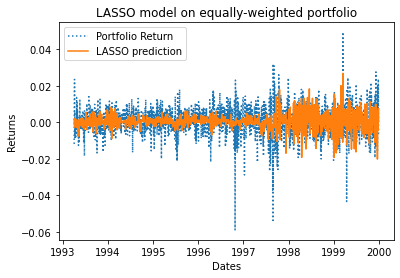

In [8]:
plt.figure()
plt.plot(result_p['Date'], result_p['Portfolio Returns'],':',  label = 'Portfolio Return')
plt.plot(result_p['Date'], result_p['Predicted Returns'], label = 'LASSO prediction')

plt.legend()

plt.xlabel('Dates')
plt.ylabel('Returns')
plt.title('LASSO model on equally-weighted portfolio')
plt.show()

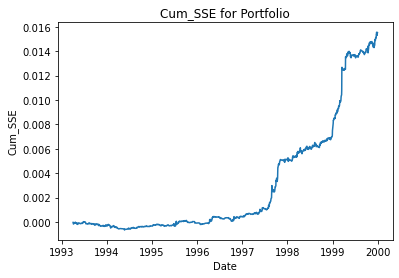

In [9]:
plt.figure()
plt.plot(result_p['Date'], result_p['Cum_SSE'])

# plt.legend()

plt.xlabel('Date')
plt.ylabel('Cum_SSE')
plt.title('Cum_SSE for Portfolio')
plt.axis('tight')
plt.show()

3.117810538097815e-05


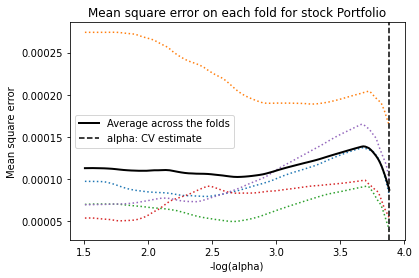

In [10]:
min_rmse = min(LA_rmse_p)
min_index = LA_rmse_p.index(min_rmse)
best_LASSO = LASSO_models_p[min_index]
print(best_LASSO.alpha_)
plot_mse('Portfolio', best_LASSO)

In [11]:
# print(best_LASSO.coef_)
# Using best LASSO model to find the efficient features for portfolio
coef_list = best_LASSO.coef_

features = pd.DataFrame()
LA_feature = []
for i in range(len(coef_list)):
    coef_x = P_full.iloc[:,i]
        
    if coef_list[i] != 0:
        features = pd.concat([features, coef_x], axis = 1)
if features.empty:
    features = P_full
print(features)
# LA_feature.append(features)


            return_40970  return_75228  return_32299  return_90916  \
1993-04-01      0.083333     -0.010363      0.100000     -0.032258   
1993-04-02     -0.038462     -0.036649      0.000000      0.000000   
1993-04-05     -0.040000      0.005435      0.090909      0.000000   
1993-04-06      0.041667     -0.010811      0.000000     -0.033333   
1993-04-07      0.040000     -0.027322     -0.083333      0.000000   
...                  ...           ...           ...           ...   
2000-12-22      0.000000      0.074640      0.000000      0.031250   
2000-12-26     -0.063830      0.001052      0.142857     -0.060606   
2000-12-27      0.090909     -0.021288     -0.125000      0.064516   
2000-12-28     -0.020833     -0.002417      0.000000     -0.030303   
2000-12-29      0.148936      0.030956      0.000000     -0.218750   

            return_70018  return_58800  return_25961  return_66245  \
1993-04-01     -0.003106      0.022152      0.009174      0.000000   
1993-04-02     -0.0